(-0.5, 4201.5, 3005.5, -0.5)

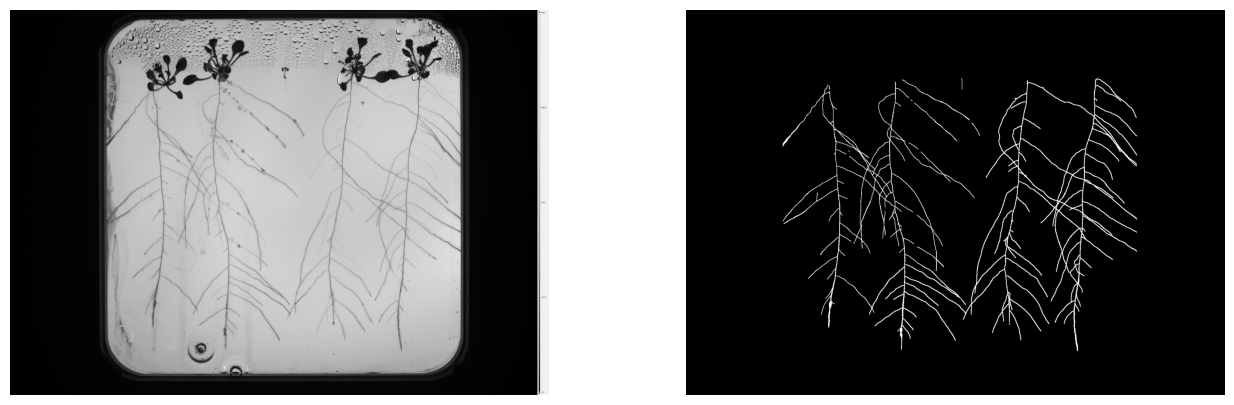

In [6]:
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

image_path = r"C:\Users\batkm\Desktop\Year2BlockB\Datasets\Y2B_23\train_images\train\014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected.png"
mask_path = r"C:\Users\batkm\Desktop\Year2BlockB\Datasets\Y2B_23\train_masks\train\014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_root_mask.tif"

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].axis('off')

In [7]:
print(f'Image shape: {image.shape}, mask shape: {mask.shape}')

Image shape: (3006, 4202), mask shape: (3006, 4202)


### Cropping

In [8]:
# Threshold for detecting the edge
threshold = 70

# Horizontal and vertical lines to analyze
horizontal_line = image[1503, 0:4112]  # Pixel values along the horizontal line
vertical_line = image[0:3006, 2056]    # Pixel values along the vertical line

# Function to find edges by looping through the line
def find_edges(line, threshold):

    left_edge, right_edge = None, None
    n = len(line)
    
    # Loop from the left to find the first transition
    for i in range(1, n):
        if line[i-1] < threshold <= line[i] or line[i-1] >= threshold > line[i]:
            left_edge = i
            break
    
    # Loop from the right to find the last transition
    for i in range(n-1, 0, -1):
        if line[i] < threshold <= line[i-1] or line[i] >= threshold > line[i-1]:
            right_edge = i
            break
    
    return left_edge, right_edge

# Function to return a slice of found edges
def format(image, mask):
    """
    Crops the image and the mask based on detected edges, ensuring a square output.

    Parameters:
        image (np.ndarray): The base image to crop.
        mask (np.ndarray): The corresponding mask to crop (same resolution as image).

    Returns:
        tuple: Cropped image and mask.
    """
    # Analyze horizontal and vertical lines in the image
    horizontal_line = image[1503, 0:4112]
    vertical_line = image[0:3006, 2056]
    left_x, right_x = find_edges(horizontal_line, threshold)
    top_y, bottom_y = find_edges(vertical_line, threshold)

    # Ensure the output region is a square
    side_length = max(right_x - left_x, bottom_y - top_y)
    right_x = left_x + side_length
    bottom_y = top_y + side_length

    # Create slices for cropping
    crop_y = slice(top_y, bottom_y)
    crop_x = slice(left_x, right_x)

    # Crop both the image and the mask
    cropped_image = image[crop_y, crop_x]
    cropped_mask = mask[crop_y, crop_x]

    return cropped_image, cropped_mask


# Analyze the horizontal line (x-coordinates)
left_x, right_x = find_edges(horizontal_line, threshold)

# Analyze the vertical line (y-coordinates)
top_y, bottom_y = find_edges(vertical_line, threshold)



In [9]:
def crop_image(image, mask):
    """
    Crops the image and mask based on detected edges and displays them with consistent color representation.

    Parameters:
        image (np.ndarray): The base image to crop.
        mask (np.ndarray): The corresponding mask to crop (same resolution as image).
    """


    # Crop the image and mask
    cropped_image, cropped_mask = format(image, mask)


    # Create subplots for visualization
    #fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 2 columns

    # Display the original image
    # axes[0, 0].imshow(image, cmap='gray', vmin=0, vmax=255)
    # axes[0, 0].axis('off')
    # axes[0, 0].set_title("Original Image")

    # # Display the cropped image
    # axes[0, 1].imshow(cropped_image, cmap='gray', vmin=0, vmax=255)
    # axes[0, 1].axis('off')
    # axes[0, 1].set_title("Cropped Image")

    # # Display the original mask
    # axes[1, 0].imshow(mask, cmap='gray')
    # axes[1, 0].axis('off')
    # axes[1, 0].set_title("Original Mask")

    # # Display the cropped mask
    # axes[1, 1].imshow(cropped_mask, cmap='gray')
    # axes[1, 1].axis('off')
    # axes[1, 1].set_title("Cropped Mask")

    # Adjust spacing and show the plot
    #plt.tight_layout()
    #plt.show()

    # Print shapes of cropped images
    #print(f"Cropped Image Shape: {cropped_image.shape}")
    #print(f"Cropped Mask Shape: {cropped_mask.shape}")

    return cropped_image, cropped_mask

cropped_image, cropped_mask = crop_image(image, mask)


In [10]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

(2816, 2816)

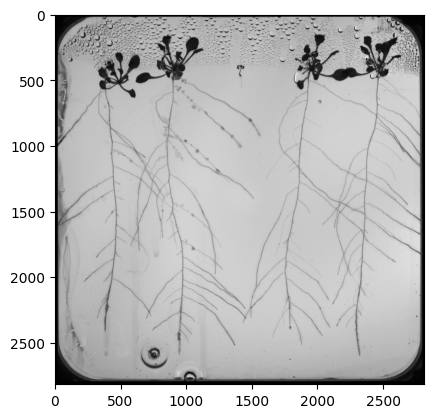

In [11]:
patch_size = 256
image = cropped_image
padded_image = padder(image, patch_size)
plt.imshow(padded_image, cmap='gray')
padded_image.shape

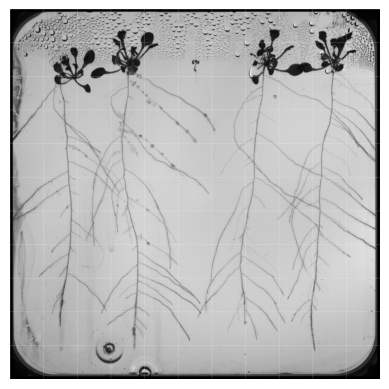

In [12]:
height, width = padded_image.shape[:2]

for x in range(0, width, patch_size):
    cv2.line(padded_image, (x, 0), (x, height), color=(255, 0, 0), thickness=1)

for y in range(0, height, patch_size):
    cv2.line(padded_image, (0, y), (width, y), color=(255, 0, 0), thickness=1)

plt.axis('off')
plt.imshow(padded_image, cmap='gray')

In [13]:
# Ensure the padded_image has three channels
if len(padded_image.shape) == 2:
	padded_image = np.expand_dims(padded_image, axis=-1)
	padded_image = np.repeat(padded_image, 3, axis=-1)

patches = patchify(padded_image, (patch_size, patch_size, 3), step=patch_size)

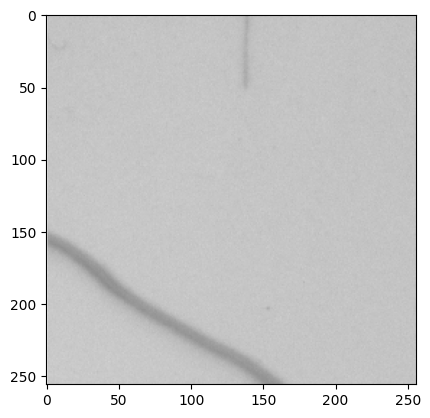

In [14]:
plt.imshow(patches[2, 5, 0])

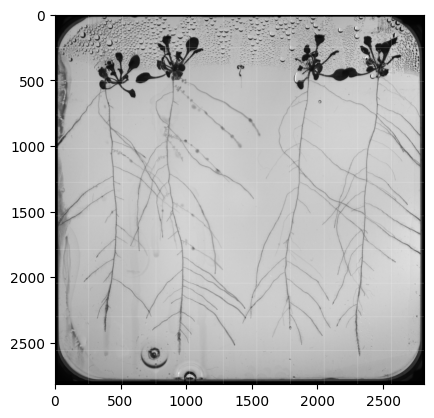

In [15]:
plt.imshow(unpatchify(patches, padded_image.shape))

### Generating the dataset

#### Pipeline for patchifying one image (for testing purposes)

Cropped image shape: (2775, 2775), dtype: uint8
Cropped mask shape: (2775, 2775), dtype: uint8
Padded image shape: (2816, 2816), dtype: uint8
Padded mask shape: (2816, 2816), dtype: uint8
Image patches shape: (11, 11, 1, 256, 256, 3)
Mask patches shape: (11, 11, 256, 256)
Saved 121 patches to test_patched_dataset


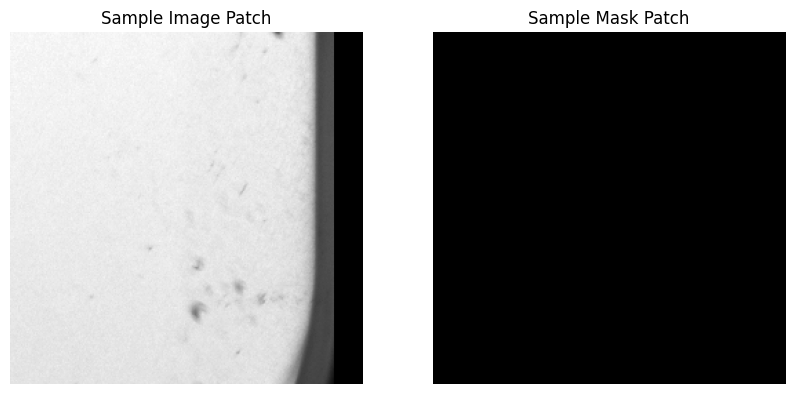

In [11]:
from patchify import patchify
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image  # For handling and saving TIFF files

def test_patching_pipeline(image_path, mask_path, patch_size, save_dir):
    """
    Pipeline to crop, pad, patchify, and save image and mask patches.

    Parameters:
        image_path (str): Path to the input image.
        mask_path (str): Path to the corresponding mask (TIFF format).
        patch_size (int): Size of patches.
        save_dir (str): Directory to save the patches.
    """
    # Step 1: Read the image and mask
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  

    # Step 2: Crop the image and mask
    cropped_image, cropped_mask = crop_image(image, mask)

    print(f"Cropped image shape: {cropped_image.shape}, dtype: {cropped_image.dtype}")
    print(f"Cropped mask shape: {cropped_mask.shape}, dtype: {cropped_mask.dtype}")

    # Step 3: Pad the cropped image and mask
    padded_image = padder(cropped_image, patch_size)
    padded_mask = padder(cropped_mask, patch_size)

    print(f"Padded image shape: {padded_image.shape}, dtype: {padded_image.dtype}")
    print(f"Padded mask shape: {padded_mask.shape}, dtype: {padded_mask.dtype}")

    # Step 4: Ensure the image is in 3 channels
    if len(padded_image.shape) == 2:  # Grayscale to 3 channels
        padded_image = np.expand_dims(padded_image, axis=-1)
        padded_image = np.repeat(padded_image, 3, axis=-1)

    # Ensure mask is in a single channel
    if len(padded_mask.shape) == 3 and padded_mask.shape[-1] == 3:
        padded_mask = padded_mask[:, :, 0]

    # Step 5: Patchify the padded image and mask
    image_patches = patchify(padded_image, (patch_size, patch_size, 3), step=patch_size)
    mask_patches = patchify(padded_mask, (patch_size, patch_size), step=patch_size)

    print(f"Image patches shape: {image_patches.shape}")
    print(f"Mask patches shape: {mask_patches.shape}")

    # Step 6: Save the patches
    image_patches_dir = os.path.join(save_dir, "image_patches")
    mask_patches_dir = os.path.join(save_dir, "mask_patches")
    os.makedirs(image_patches_dir, exist_ok=True)
    os.makedirs(mask_patches_dir, exist_ok=True)

    patch_count = 0
    for i in range(image_patches.shape[0]):
        for j in range(image_patches.shape[1]):
            # Save image patch as PNG
            img_patch = image_patches[i, j, 0]
            cv2.imwrite(os.path.join(image_patches_dir, f"patch_{patch_count}.png"), img_patch)

            # Save mask patch as TIFF
            mask_patch = mask_patches[i, j]
            mask_patch = mask_patch.reshape((patch_size, patch_size, 1))
            cv2.imwrite(os.path.join(mask_patches_dir, f"patch_{patch_count}.tif"), mask_patch)

            patch_count += 1

    print(f"Saved {patch_count} patches to {save_dir}")


# Test the pipeline with one image and its TIFF mask
test_image_path = 'Y2B_23/train_images/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected.png'
test_mask_path = 'Y2B_23/train_masks/train/014_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_03-Fish Eye Corrected_root_mask.tif'

patch_size = 256  # Example patch size
save_directory = "test_patched_dataset"  # Directory to save patches

test_patching_pipeline(test_image_path, test_mask_path, patch_size, save_directory)

rand_patch = np.random.randint(0, 120)

# Visualize some patches for verification
sample_image_patch = cv2.imread(os.path.join(save_directory, f"image_patches/patch_{rand_patch}.png"), cv2.IMREAD_GRAYSCALE)
sample_mask_patch = cv2.imread(os.path.join(save_directory, f"mask_patches/patch_{rand_patch}.tif"), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image_patch, cmap="gray")
plt.title("Sample Image Patch")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sample_mask_patch, cmap="gray")
plt.title("Sample Mask Patch")
plt.axis("off")
plt.show()


##### As observed above, the function works correctly on 1 image, now it's time to apply it on the whole dataset...

### Adjusted patchifying function for dataset patchifying application:

The funciton splits the patches into a desired train/val split (defined by the train_ration variable), and puts the patches into one folder:

In [23]:
def patching_pipeline(image_path, mask_path, patch_size=256, save_dir=""):
    """
    Pipeline to crop, pad, patchify, and save image and mask patches into structured directories.

    Parameters:
        image_path (str): Path to the input image.
        mask_path (str): Path to the corresponding mask.
        patch_size (int): Size of patches.
        save_dir (str): Directory to save the patches.
    """
    # Step 1: Read the image and mask
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Step 2: Crop the image and mask
    cropped_image, cropped_mask = crop_image(image, mask)

    # Step 3: Pad the cropped image and mask
    padded_image = padder(cropped_image, patch_size)
    padded_mask = padder(cropped_mask, patch_size)

    # Step 4: Ensure the image is in 3 channels
    if len(padded_image.shape) == 2:  # Grayscale to 3 channels
        padded_image = np.expand_dims(padded_image, axis=-1)
        padded_image = np.repeat(padded_image, 3, axis=-1)

    # Ensure mask is in a single channel
    if len(padded_mask.shape) == 3 and padded_mask.shape[-1] == 3:
        padded_mask = padded_mask[:, :, 0]

    # Step 5: Patchify the padded image and mask
    image_patches = patchify(padded_image, (patch_size, patch_size, 3), step=128)
    mask_patches = patchify(padded_mask, (patch_size, patch_size), step=128)

    # Determine the subdirectories for saving
    if "train_images" in image_path:
        image_dir = os.path.join(save_dir, "train_images/train")
        mask_dir = os.path.join(save_dir, "train_masks/train")
    elif "val_images" in image_path:
        image_dir = os.path.join(save_dir, "val_images/val")
        mask_dir = os.path.join(save_dir, "val_masks/val")
    else:
        raise ValueError(f"Invalid directory structure for: {image_path}")

    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    # Save the patches
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    patch_count = 0

    for i in range(image_patches.shape[0]):
        for j in range(image_patches.shape[1]):
            img_patch = image_patches[i, j, 0]
            mask_patch = mask_patches[i, j]
            mask_patch = mask_patch.reshape((patch_size, patch_size, 1))

            # Save patches
            img_patch_path = os.path.join(image_dir, f"{base_name}_patch_{patch_count}.png")
            mask_patch_path = os.path.join(mask_dir, f"{base_name}_patch_{patch_count}.tif")
            cv2.imwrite(img_patch_path, img_patch)
            cv2.imwrite(mask_patch_path, mask_patch)

            patch_count += 1


### Function to loop through the whole dataset, and apply the function defined above:

In [24]:
def patchify_dataset(input_directory, patch_size, save_directory):
    """
    Processes a dataset of images and corresponding masks, patchifying each pair based on directory structure.

    Parameters:
        input_directory (str): Directory containing images and masks in a structured format.
        patch_size (int): Size of the patches.
        save_directory (str): Directory to save the patches.
    """
    # Walk through the input directory structure
    for root, dirs, files in os.walk(input_directory):
        for file_name in files:
            if not file_name.lower().endswith(('.png', '.tif', '.jpg')):
                print(f"Skipping invalid file: {file_name}")
                continue

            file_path = os.path.join(root, file_name)

            # Determine if the current file is an image or mask
            if "train_images" in root or "val_images" in root:
                # Corresponding mask path
                mask_path = file_path.replace("images", "masks").replace(".png", "_root_mask.tif")
                if not os.path.exists(mask_path):
                    print(f"Skipping {file_name}: Corresponding mask not found.")
                    continue

                # Patchify image and mask
                patching_pipeline(file_path, mask_path, patch_size, save_directory)
            elif "train_masks" in root or "val_masks" in root:
                # Skip processing masks directly
                continue

    print("Dataset processing completed.")


In [25]:
input_directory = r"C:\Users\batkm\Desktop\Year2BlockB\Datasets\Y2B_23"
save_directory = r"C:\Users\batkm\Desktop\Year2BlockB\Datasets\23_v6"
patch_size = 256

patchify_dataset(input_directory, patch_size, save_directory)


Skipping invalid file: readme.txt
Skipping 019_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_03-Fish Eye Corrected.png: Corresponding mask not found.
Skipping 019_43-6-ROOT1-2023-08-08_control_pH7_-Fe+B_col0_01-Fish Eye Corrected.png: Corresponding mask not found.
Skipping 023_43-14-ROOT1-2023-08-08_pvdCherry_OD0001_f6h1_03-Fish Eye Corrected.png: Corresponding mask not found.
Skipping 023_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_01-Fish Eye Corrected.png: Corresponding mask not found.
Skipping 037_43-11-ROOT1-2023-08-08_mock_pH5_f6h1_01-Fish Eye Corrected.png: Corresponding mask not found.
Skipping 037_43-14-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_04-Fish Eye Corrected.png: Corresponding mask not found.
Skipping 037_43-18-ROOT1-2023-08-08_mock_pH5_+Fe_Col0_04-Fish Eye Corrected.png: Corresponding mask not found.
Skipping 000_43-18-ROOT1-2023-08-08_pvdCherry_OD001_Col0_01-Fish Eye Corrected.png: Corresponding mask not found.
Skipping 000_43-2-ROOT1-2023-08-08_pvd_OD0001_f6h1_02-Fish Eye Corrected.png:

### Now with the dataset obtained, we can check a random patch, the corresponding mask, and create an overlay:

Selected val Patch Pair:
  Image: C:\Users\batkm\Desktop\Year2BlockB\Datasets\23_v6\val_images\val\001_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish Eye Corrected_patch_437.png
  Mask: C:\Users\batkm\Desktop\Year2BlockB\Datasets\23_v6\val_masks\val\001_43-6-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish Eye Corrected_patch_437.tif


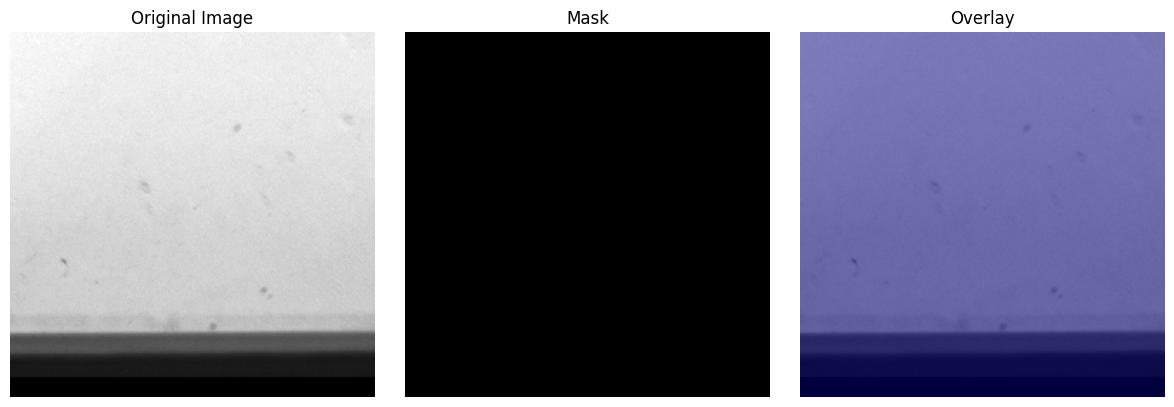

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

def visualize_random_patch(patches_dir):
    """
    Visualizes a random image patch, its corresponding mask patch, and an overlay.

    Parameters:
        patches_dir (str): Directory containing the train and val subfolders for images and masks.
    """
    # Randomly decide whether to visualize from train or validation set
    dataset_type = random.choice(["train", "val"])
    image_dir = os.path.join(patches_dir, f"{dataset_type}_images", dataset_type)
    mask_dir = os.path.join(patches_dir, f"{dataset_type}_masks", dataset_type)

    # Check if directories exist and contain patches
    if not os.path.exists(image_dir) or not os.path.exists(mask_dir):
        print(f"Dataset structure not found in {patches_dir}.")
        return

    image_patches = sorted(os.listdir(image_dir))
    mask_patches = sorted(os.listdir(mask_dir))

    if not image_patches or not mask_patches:
        print(f"No patches found in {dataset_type} dataset.")
        return

    # Randomly select an image and corresponding mask
    random_index = random.randint(0, len(image_patches) - 1)
    img_patch_path = os.path.join(image_dir, image_patches[random_index])
    mask_patch_path = os.path.join(mask_dir, mask_patches[random_index])

    # Print the selected pair for manual reference
    print(f"Selected {dataset_type} Patch Pair:")
    print(f"  Image: {img_patch_path}")
    print(f"  Mask: {mask_patch_path}")

    # Read the image and mask patches
    img_patch = cv2.imread(img_patch_path, cv2.IMREAD_GRAYSCALE)
    mask_patch = cv2.imread(mask_patch_path, cv2.IMREAD_GRAYSCALE)

    if img_patch is None or mask_patch is None:
        print(f"Error reading patches: {img_patch_path}, {mask_patch_path}")
        return

    # Create overlay
    overlay = img_patch.copy()
    overlay[mask_patch > 0] = 255  # Highlight mask regions in the overlay

    # Display the results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_patch, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_patch, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img_patch, cmap="gray")
    plt.imshow(mask_patch, cmap="jet", alpha=0.5)
    plt.title("Overlay")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Directory containing patched dataset
patched_dataset_dir = r"C:\Users\batkm\Desktop\Year2BlockB\Datasets\23_v6"

# Visualize a random patch
visualize_random_patch(patched_dataset_dir)


In [17]:
import os
import shutil

def combine_datasets(dataset1_dir, dataset2_dir, combined_dir):
    """
    Combines two datasets with the same structure into a single dataset directory.

    Parameters:
        dataset1_dir (str): Path to the first dataset.
        dataset2_dir (str): Path to the second dataset.
        combined_dir (str): Path to the combined dataset output directory.
    """
    # Define subfolders to merge
    subfolders = [
        "train_images/train",
        "train_masks/train",
        "val_images/val",
        "val_masks/val"
    ]

    for subfolder in subfolders:
        # Create the combined subfolder if it doesn't exist
        combined_subfolder = os.path.join(combined_dir, subfolder)
        os.makedirs(combined_subfolder, exist_ok=True)

        # Copy files from dataset1
        dataset1_subfolder = os.path.join(dataset1_dir, subfolder)
        if os.path.exists(dataset1_subfolder):
            for file in os.listdir(dataset1_subfolder):
                src_path = os.path.join(dataset1_subfolder, file)
                dst_path = os.path.join(combined_subfolder, file)
                shutil.copy(src_path, dst_path)

        # Copy files from dataset2
        dataset2_subfolder = os.path.join(dataset2_dir, subfolder)
        if os.path.exists(dataset2_subfolder):
            for file in os.listdir(dataset2_subfolder):
                src_path = os.path.join(dataset2_subfolder, file)
                dst_path = os.path.join(combined_subfolder, file)

                # Handle potential filename conflicts
                if os.path.exists(dst_path):
                    base_name, ext = os.path.splitext(file)
                    new_file_name = f"{base_name}_24{ext}"  # Add a prefix for dataset2 files
                    dst_path = os.path.join(combined_subfolder, new_file_name)

                shutil.copy(src_path, dst_path)

    print(f"Combined datasets saved to: {combined_dir}")


In [18]:
dataset1_dir = "24_patched_dataset"
dataset2_dir = "patched_dataset"
combined_dir = "combined_patched_dataset"

combine_datasets(dataset1_dir, dataset2_dir, combined_dir)


KeyboardInterrupt: 